In [52]:
import numpy as np
import seaborn as sns
import pandas as pd
filepath = './weather_data.csv'
data = pd.read_csv(filepath)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB


In [54]:
data.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


In [55]:
data.shape

(311, 7)

<Axes: >

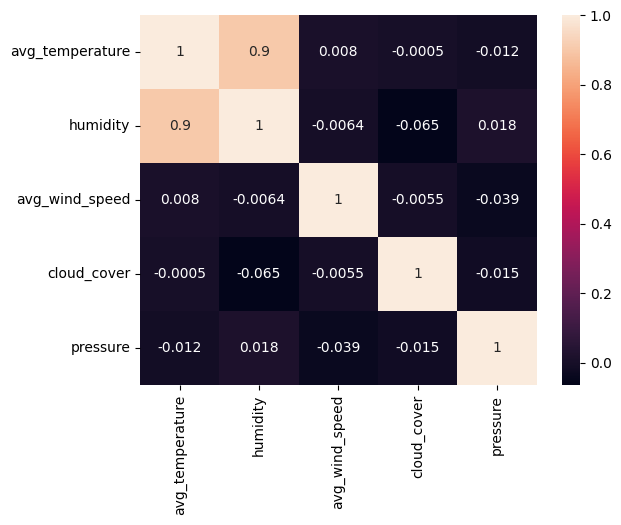

In [56]:
features_data = data.select_dtypes('float64','int64')
features_data.head()
sns.heatmap(features_data.corr(), annot=True)

In [57]:
#encoding rain_or_not to binary format
# rain =1 not =0
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df = data.copy()
df['rain_or_not'] = encoder.fit_transform(df['rain_or_not'])
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mapping

{'No Rain': np.int64(0), 'Rain': np.int64(1)}

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    int64  
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 17.1+ KB


In [59]:
df.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331


In [60]:
data.isnull().sum().sort_values()

date                0
rain_or_not         0
pressure            0
avg_temperature    15
humidity           15
avg_wind_speed     15
cloud_cover        15
dtype: int64

In [61]:
df.drop_duplicates()
# fill null values using forward fill
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sort_values()

# df.describe()

/var/folders/h6/189g986n3f1__69ykjd_sgjm0000gn/T/ipykernel_95601/3002243908.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
dtype: int64

In [62]:
# Create a list of float colums to check for skewing
mask = df.dtypes == np.float64
float_cols = df.columns[mask]
float_cols
skew_limit = 0.75
skew_vals = df[float_cols].skew()
skew_vals

avg_temperature   -0.221499
humidity          -0.025938
avg_wind_speed     2.725921
cloud_cover       -0.063843
pressure          -0.075223
dtype: float64

In [63]:
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
avg_wind_speed,2.725921


In [64]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
feild = "avg_wind_speed"
# fig, (ax_before, ax_after) = plt.subplots(1,2, figsize=(10,5))

# df[feild].hist(ax=ax_before)
# df[feild].apply(lambda x: np.log1p(x)).hist(ax=ax_after)
# boxcox(df['avg_wind_speed'] + 1).hist(ax=ax_after)
# df[feild] = df[feild].apply(lambda x: np.log1p(x))
df[feild],_ = boxcox(df[feild] + 1)

In [65]:
df[float_cols].skew()

avg_temperature   -0.221499
humidity          -0.025938
avg_wind_speed     0.010856
cloud_cover       -0.063843
pressure          -0.075223
dtype: float64

In [66]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df.drop(columns=['rain_or_not', 'date'])  # Drop non-relevant columns
y = df['rain_or_not']

# Split into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (248, 5)
Test set size: (63, 5)


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.6984
Decision Tree Accuracy: 0.5556
Random Forest Accuracy: 0.6508
Gradient Boosting Accuracy: 0.6190


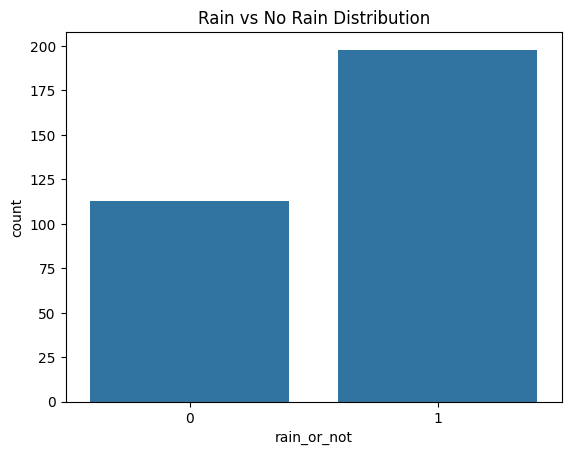

rain_or_not
1    0.636656
0    0.363344
Name: proportion, dtype: float64


In [68]:
sns.countplot(x=df['rain_or_not'])
plt.title("Rain vs No Rain Distribution")
plt.show()

print(df['rain_or_not'].value_counts(normalize=True))  # Check percentage

In [70]:
logreg = LogisticRegression(class_weight="balanced")  # Adjusts weights automatically
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

print(f"Logistic Regression (Balanced) Accuracy: {accuracy_logreg:.4f}")

Logistic Regression (Balanced) Accuracy: 0.6190


In [71]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(feature_importances.sort_values(ascending=False))

humidity           0.229154
avg_temperature    0.212226
pressure           0.204934
avg_wind_speed     0.187783
cloud_cover        0.165904
dtype: float64


In [73]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logreg_poly = LogisticRegression(max_iter=1000)
logreg_poly.fit(X_train_poly, y_train)

y_pred_poly = logreg_poly.predict(X_test_poly)
accuracy_poly = accuracy_score(y_test, y_pred_poly)

print(f"Polynomial Logistic Regression Accuracy: {accuracy_poly:.4f}")

Polynomial Logistic Regression Accuracy: 0.6667


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

y_pred_scaled = logreg.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

print(f"Scaled Logistic Regression Accuracy: {accuracy_scaled:.4f}")

Scaled Logistic Regression Accuracy: 0.6825


In [82]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy (Scaled): {accuracy_xgb:.4f}")

XGBoost Accuracy (Scaled): 0.6190


In [86]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost model
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=5, eval_metric="logloss", random_state=42)

# Train with early stopping
xgb.fit(X_train_scaled, y_train, 
        eval_set=[(X_test_scaled, y_test)], 
        early_stopping_rounds=20, 
        verbose=True)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy (Early Stopping): {accuracy_xgb:.4f}")

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'